In [1]:
import numpy as np
import pandas as pd
from itertools import chain
from model.SVD_Label import SVD_Label

# Setting 

In [2]:
FD_DATA = './data/'
FD_WEIGHT = './weight/'
FN_DATA = FD_DATA + 'data_sample.csv'
FN_WEIGHT = FD_WEIGHT + 'weight_SVD.p'

# Load Data

In [3]:
df = pd.read_csv(FN_DATA, encoding='latin-1')
N = df.shape[0]

df.columns, N

(Index(['DESC', 'LABEL', 'LABEL_DESC'], dtype='object'), 9327)

## Map label to label description 

In [4]:
map_l2d = dict(df.groupby(by='LABEL')['LABEL_DESC'].first().reset_index().values.tolist())

# Train SVD Labeller

In [5]:
model = SVD_Label(n_components=22)

In [6]:
universe_desc = set(chain.from_iterable(df.DESC.str.split().values))
universe_label = set(df.LABEL.values)

model.build(universe_x=universe_desc, universe_y=universe_label)

In [7]:
model.compile()

Explained variance: 0.9996989143334679


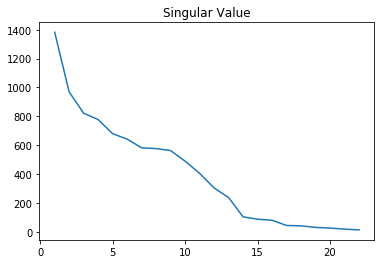

In [8]:
x = df.DESC.str.split().values
y_true = df.LABEL.values

model.fit(x, y_true, verbose=True)

In [9]:
model.save_model(FN_WEIGHT)

# Validate

In [10]:
model.load_model(FN_WEIGHT)

In [11]:
y_pred = model.predict(x)

In [12]:
perc_match = (y_pred == y_true).sum() / N
perc_match

0.7997212394124584

In [13]:
label_pred = np.asarray([ map_l2d[x] for x in y_pred ])

df_result = df.copy()
df_result['LABEL_DESC_INFER'] = label_pred

In [14]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', -1)

# df_result[df_result['LABEL_DESC'] != df_result['LABEL_DESC_INFER']]